<a href="https://colab.research.google.com/github/PozzOver13/learning/blob/main/time_series/udemy_volkswagen_businesscase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the Packages

In [1]:
# !pip install pmdarima

In [2]:
# !pip install arch

In [3]:
# !pip install yfinance

In [4]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Importing the Data

In [5]:
raw_data = yfinance.download (tickers = "VOW3.DE, PAH3.DE, BMW.DE", interval = "1d", group_by = 'ticker',
                              auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [6]:
df = raw_data.copy()

## Defining Key Dates

In [7]:
# Starting Date
start_date = "2009-04-05" 

# First Official Announcement - 49.9%
ann_1 = "2009-12-09" 

# Second Official Announcement - 51.1%
ann_2 = "2012-07-05" 

# Ending Date
end_date = "2014-01-01"

# Dieselgate
d_gate = '2015-09-20' 

## Pre-processing the Data

In [8]:
# Extracting Closing Prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Creating Returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns
df['sq_vol'] = df['ret_vol'].mul(df.ret_vol)
df['sq_por'] = df['ret_por'].mul(df.ret_por)
df['sq_bmw'] = df['ret_bmw'].mul(df.ret_bmw)

# Extracting Volume
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [9]:
# Assigning the Frequency and Filling NA Values
df = df.asfreq('b')
df = df.fillna(method='bfill')

In [10]:
# Removing Surplus Data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

## Plotting the Prices

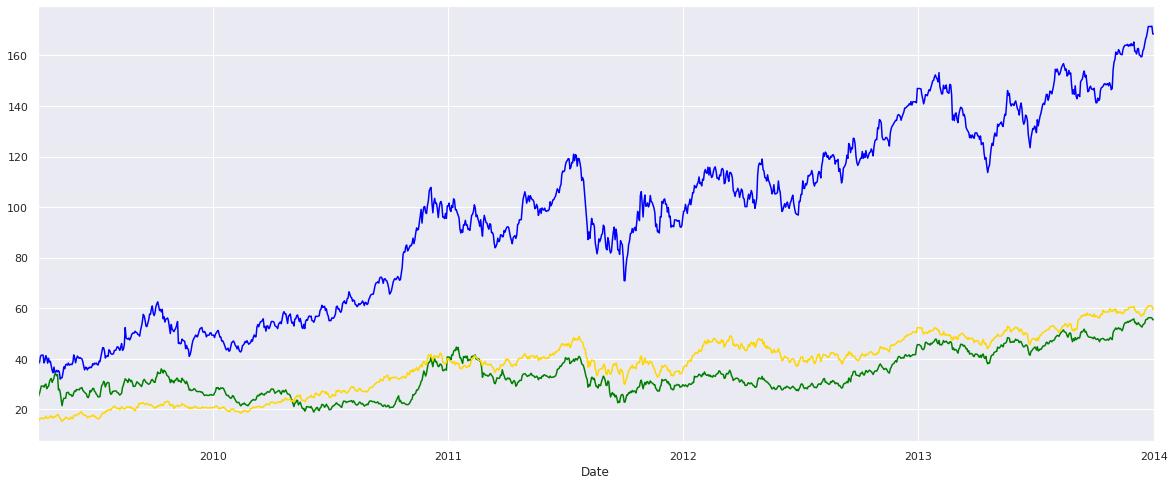

In [11]:
df['vol'][start_date:end_date].plot(figsize= (20,8), color = "blue")
df['por'][start_date:end_date].plot(color = "green")
df['bmw'][start_date:end_date].plot(color = "gold")
plt.show()

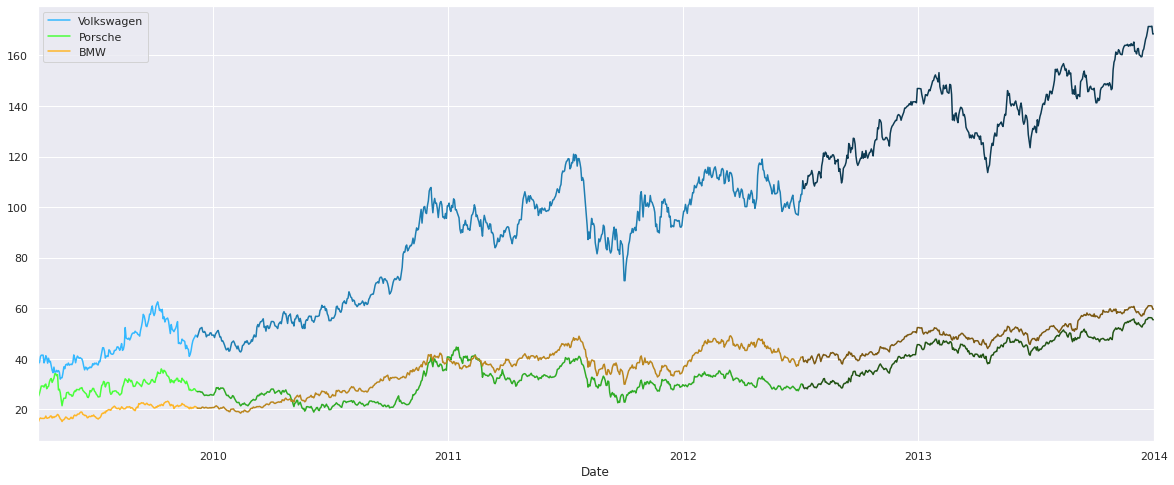

In [12]:
df['vol'][start_date:ann_1].plot(figsize= (20,8), color = "#33B8FF")
df['por'][start_date:ann_1].plot(color = "#49FF3A")
df['bmw'][start_date:ann_1].plot(color = "#FEB628")

df['vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['por'][ann_1:ann_2].plot(color = "#2FAB25")
df['bmw'][ann_1:ann_2].plot(color = "#BA861F")

df['vol'][ann_2:end_date].plot(color = "#0E3A52")
df['por'][ann_2:end_date].plot(color = "#225414")
df['bmw'][ann_2:end_date].plot(color = "#7C5913")

plt.legend(['Volkswagen','Porsche','BMW'])

plt.show()

## Correlation

In [18]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
df.loc[start_date:end_date, ['vol', 'por', 'bmw']].corr().round(3)

Correlation among manufacturers from 2009-04-05 to 2014-01-01



,,vol,por,bmw
,,,,
vol,,1.000,0.836,0.980
por,,0.836,1.000,0.805
bmw,,0.980,0.805,1.000


In [19]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1)+ '\n')
df.loc[start_date:ann_1, ['vol', 'por', 'bmw']].corr().round(3)

Correlation among manufacturers from 2009-04-05 to 2009-12-09



,,vol,por,bmw
,,,,
vol,,1.000,0.663,0.843
por,,0.663,1.000,0.610
bmw,,0.843,0.610,1.000


In [20]:
print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2)+ '\n')
df.loc[ann_1:ann_2, ['vol', 'por', 'bmw']].corr().round(3)

Correlation among manufacturers from 2009-12-09 to 2012-07-05



,,vol,por,bmw
,,,,
vol,,1.000,0.743,0.980
por,,0.743,1.000,0.704
bmw,,0.980,0.704,1.000


In [21]:
print('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date)+ '\n')
df.loc[ann_2:end_date, ['vol', 'por', 'bmw']].corr().round(3)

Correlation among manufacturers from 2012-07-05 to 2014-01-01



,,vol,por,bmw
,,,,
vol,,1.000,0.941,0.928
por,,0.941,1.000,0.949
bmw,,0.928,0.949,1.000


In [23]:
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1])+ '\n')
df.loc[end_date:, ['vol', 'por', 'bmw']].corr().round(3)

Correlation among manufacturers from 2014-01-01 to 2022-03-24 00:00:00



,,vol,por,bmw
,,,,
vol,,1.000,0.926,0.702
por,,0.926,1.000,0.770
bmw,,0.702,0.770,1.000


## Best Fitting Models

### For Volkswagen

In [24]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por','bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [25]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -322.988
Date:                Fri, 25 Mar 2022   AIC                            655.976
Time:                        06:46:13   BIC                            671.885
Sample:                    04-06-2009   HQIC                           662.427
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7232      0.447      1.618      0.106      -0.153       1.599
por            0.4000      0.096      4.168      0.000       0.212       0.588
bmw            0.6919      0.328      2.107      0.035       0.048       1.335
ar.L1          0.9633      0.020     48.670      0.000       0.925       1.002
sigma2         2.1737      0.148     14.718      0.000       1.884       2.463
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):               166.03
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1080.051
Date:                Fri, 25 Mar 2022   AIC                           2166.102
Time:                        06:46:30   BIC                           2179.628
Sample:                    12-09-2009   HQIC                          2171.341
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.7908      0.062     12.842      0.000       0.670       0.912
bmw            1.5487      0.073     21.269      0.000       1.406       1.691
sigma2         1.4643      0.060     24.532      0.000       1.347       1.581
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):               112.42
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -607.774
Date:                Fri, 25 Mar 2022   AIC                           1221.547
Time:                        06:46:42   BIC                           1233.438
Sample:                    07-05-2012   HQIC                          1226.261
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.7190      0.057     30.369      0.000       1.608       1.830
bmw            0.8575      0.091      9.381      0.000       0.678       1.037
sigma2         1.3323      0.065     20.461      0.000       1.205       1.460
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               103.79
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### For Porsche

In [28]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol','bmw']][ann_2:end_date],
                             m = 5, max_p = 5, max_q = 5)

In [29]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -225.800
Date:                Fri, 25 Mar 2022   AIC                            463.601
Time:                        06:47:30   BIC                            482.692
Sample:                    04-06-2009   HQIC                           471.343
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5755      0.375      1.533      0.125      -0.160       1.311
vol            0.1150      0.053      2.157      0.031       0.011       0.219
bmw            0.8819      0.159      5.558      0.000       0.571       1.193
ar.L1          1.0748      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.7319      0.052     14.098      0.000       0.630       0.834
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               559.40
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -580.934
Date:                Fri, 25 Mar 2022   AIC                           1171.867
Time:                        06:47:35   BIC                           1194.411
Sample:                    12-09-2009   HQIC                          1180.599
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.1785      0.016     11.134      0.000       0.147       0.210
bmw            0.3317      0.046      7.200      0.000       0.241       0.422
ar.L1          0.6585      0.230      2.860      0.004       0.207       1.110
ma.L1         -0.5898      0.246     -2.394      0.017      -1.073      -0.107
sigma2         0.3308      0.010     32.415      0.000       0.311       0.351
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1076.53
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -210.239
Date:                             Fri, 25 Mar 2022   AIC                            428.477
Time:                                     06:47:39   BIC                            444.331
Sample:                                 07-05-2012   HQIC                           434.762
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2219      0.013     16.876      0.000       0.196       0.248
bmw            0.2504      0.041      6.036      0.000       0.169       0.332
ma.S.L5       -0.1249      0.057     -2.210      0.027      -0.236      -0.014
sigma2         0.1725      0.006     27.851      0.000       0.160       0.185
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):               613.59
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions for the Future

### For Porsche

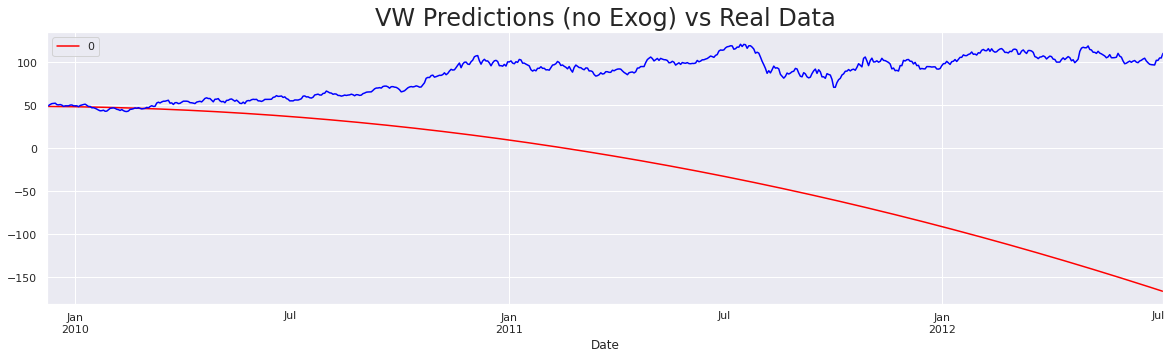

In [32]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2])), index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data", size = 24)
plt.show()

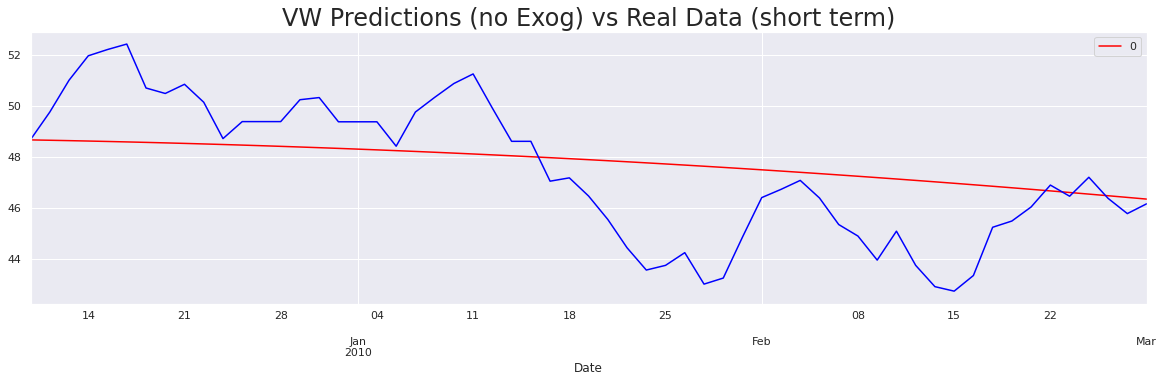

In [33]:
df_auto_pred_pr[ann_1:'2010-03-01'].plot(figsize = (20,5), color = "red")
df.vol[ann_1:'2010-03-01'].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data (short term)", size = 24)
plt.show()

### For Volkswagen

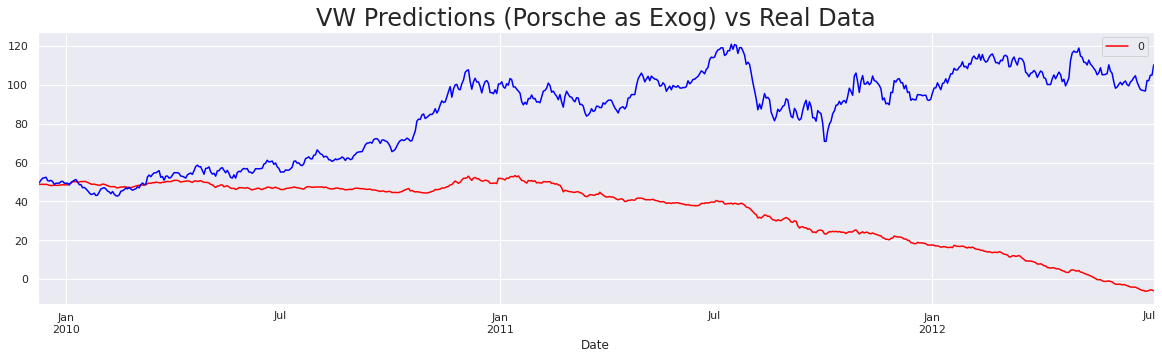

In [34]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),exogenous = df[['por']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche as Exog) vs Real Data", size = 24)
plt.show()

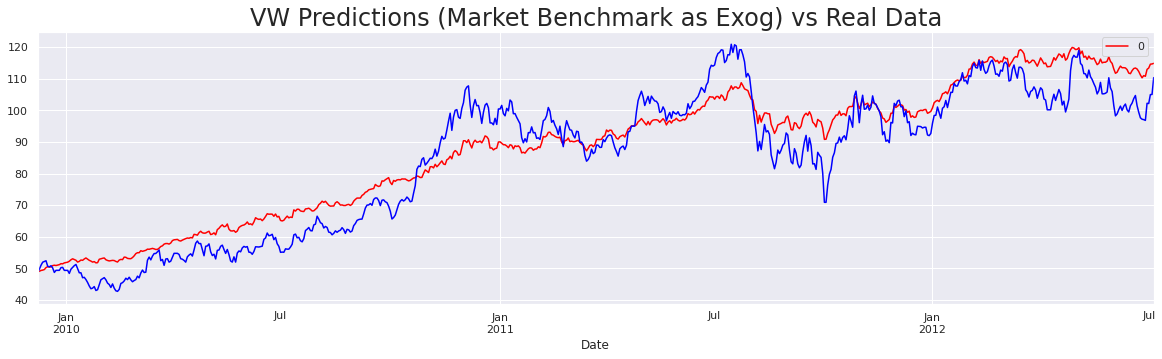

In [35]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['bmw']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['bmw']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Market Benchmark as Exog) vs Real Data", size = 24)
plt.show()

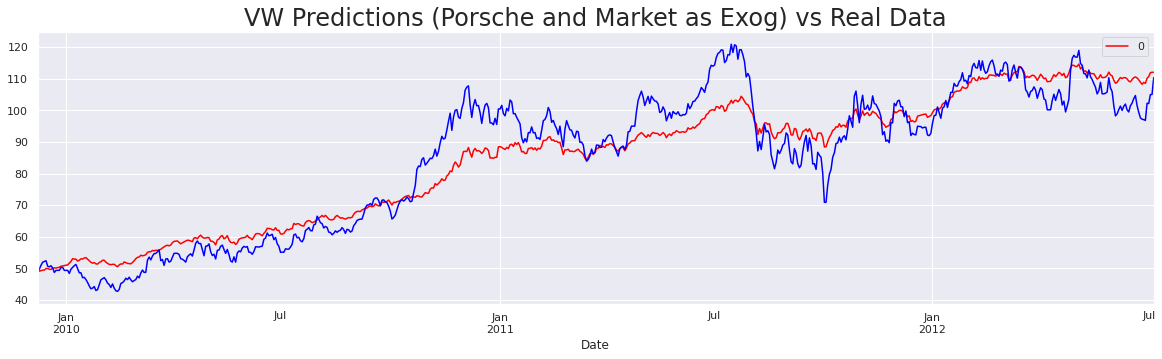

In [36]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por', 'bmw']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['por','bmw']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche and Market as Exog) vs Real Data", size = 24)
plt.show()

## Volatility

### Volatility of VW for Each Period

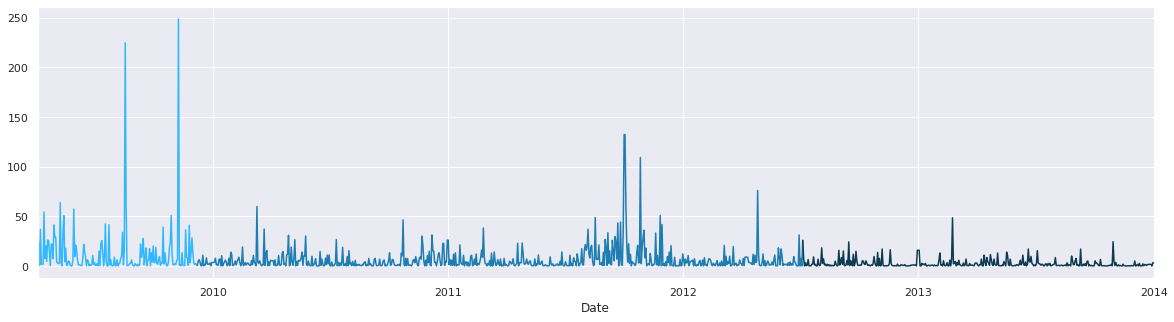

In [37]:
df['sq_vol'][start_date:ann_1].plot(figsize = (20,5), color = "#33B8FF")
df['sq_vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['sq_vol'][ann_2:end_date].plot(color = "#0E3A52")
plt.show()

### Volatility Trends for Each Period

In [38]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     35,   Neg. LLF: 475.80957221332926
Iteration:     10,   Func. Count:     65,   Neg. LLF: 475.02917132949267
Iteration:     15,   Func. Count:     95,   Neg. LLF: 474.9904701779595
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 474.9904701256666
            Iterations: 15
            Function evaluations: 95
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     42,   Neg. LLF: 1526.922517323085
Iteration:     10,   Func. Count:     72,   Neg. LLF: 1526.7313709597092
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1526.7313709584648
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     38,   Neg. LLF: 724.5621049006775
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 724.557884778142
            Iterations: 7
          

In [39]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.990
Distribution:                  Normal   AIC:                           957.981
Method:            Maximum Likelihood   BIC:                           970.708
                                        No. Observations:                  178
Date:                Fri, Mar 25 2022   Df Residuals:                      177
Time:                        06:50:18   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1570      0.266      0.589      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6196      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.195e-02      1.675  9.400e-02 [-2.623e-02,  0.334]
beta[1]    3.0192e-13      0.349  8.645e-13      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

In [40]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Fri, Mar 25 2022   Df Residuals:                      671
Time:                        06:50:18   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.883      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

In [41]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Fri, Mar 25 2022   Df Residuals:                      389
Time:                        06:50:18   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.686e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.554,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.990e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""